## Fashion MNIST Model

In [1]:
## Import libs
import torch
from torch import nn

import torchvision
from torchvision import transforms
from torchvision import datasets

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# Download the data

train_data = datasets.FashionMNIST(root = "data",
                                   download = True,
                                   train = True,
                                   transform = transforms.ToTensor())

test_data = datasets.FashionMNIST(root = "data",
                                  download = True,
                                  train = False,
                                  transform = transforms.ToTensor())

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.9MB/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 202kB/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.30MB/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 6.75MB/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [4]:
train_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
len(train_data), len(test_data)

(60000, 10000)

In [6]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [7]:
# Create the dataloaders
from torch.utils.data import DataLoader

# Batch Size
BATCH_SIZE = 32

# Train Dataloader
train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              shuffle = True
                              )

test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             shuffle = False
                             )

len(train_dataloader), len(test_dataloader)

(1875, 313)

In [8]:
# Create the model

class FashionMNIST_Model_V1(nn.Module):
  def __init__(self, input_shape:int,
               output_shape: int,
               hidden_units: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1
                  ),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  stride = 1,
                  padding = 1,
                  kernel_size = 3),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  stride = 1,
                  padding = 1,
                  kernel_size = 3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units * 7 * 7 ,
                  out_features = output_shape)
        )

  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x

In [9]:
# Instantiate the model
model_1 = FashionMNIST_Model_V1(input_shape = 1,
                                output_shape = len(class_names),
                                hidden_units = 10).to(device)
model_1

FashionMNIST_Model_V1(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [10]:
train_data[0][0].shape

torch.Size([1, 28, 28])

In [11]:
# Setup loss
loss_fn = nn.CrossEntropyLoss()

# Setup optimizer
optimizer = torch.optim.SGD(params = model_1.parameters(),
                         lr = 0.1)

In [12]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 21.1 MB/s eta 0:00:00


In [13]:
# Setup metrics
from tqdm.auto import tqdm
from torchmetrics import Accuracy

acc_fn = Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device)

In [14]:
# Setup metrics
from tqdm.auto import tqdm
from torchmetrics import Accuracy

acc_fn = Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device)

# Setup training/testing loop
epochs = 5
for epoch in tqdm(range(epochs)):
  train_loss, test_loss_total = 0, 0
  train_acc, test_acc = 0, 0

  ### Training
  model_1.train()
  for batch, (X_train, y_train) in enumerate(train_dataloader):
    X_train, y_train = X_train.to(device), y_train.to(device)

    # Forward pass and loss
    y_pred = model_1(X_train)
    loss = loss_fn(y_pred, y_train)
    train_loss += loss
    train_acc += acc_fn(y_pred, y_train)

    # Backprop and gradient descent
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # Adjust the loss/acc (find the loss/acc per epoch)
  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    for batch, (X_test, y_test) in enumerate(test_dataloader):
      X_test, y_test = X_test.to(device), y_test.to(device)

      # Forward pass and loss
      y_pred_test = model_1(X_test)
      test_loss = loss_fn(y_pred_test, y_test)
      test_loss_total += test_loss

      test_acc += acc_fn(y_pred_test, y_test)

    # Adjust the loss/acc (find the loss/acc per epoch)
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

  # Print out what's happening
  print(f"Epoch: {epoch} | Train loss: {train_loss:.3f} | Train acc: {train_acc:.2f} | Test loss: {test_loss_total:.3f} | Test acc: {test_acc:.2f}")


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 0.630 | Train acc: 0.77 | Test loss: 122.318 | Test acc: 0.86
Epoch: 1 | Train loss: 0.359 | Train acc: 0.87 | Test loss: 113.001 | Test acc: 0.87
Epoch: 2 | Train loss: 0.320 | Train acc: 0.89 | Test loss: 101.850 | Test acc: 0.88
Epoch: 3 | Train loss: 0.301 | Train acc: 0.89 | Test loss: 101.583 | Test acc: 0.89
Epoch: 4 | Train loss: 0.286 | Train acc: 0.90 | Test loss: 92.479 | Test acc: 0.89


In [17]:
# Make predictions with trained model_2
test_preds = []
model_1.eval()
with torch.inference_mode():
  for X_test, y_test in tqdm(test_dataloader):
    y_logits = model_1(X_test.to(device))
    y_pred_probs = torch.softmax(y_logits, dim=1)
    y_pred_labels = torch.argmax(y_pred_probs, dim=1)
    test_preds.append(y_pred_labels)
test_preds = torch.cat(test_preds).cpu() # matplotlib likes CPU
test_preds[:10], len(test_preds)

  0%|          | 0/313 [00:00<?, ?it/s]

(tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7]), 10000)

In [18]:
# Get wrong prediction indexes
import numpy as np
wrong_pred_indexes = np.where(test_preds != test_data.targets)[0]
len(wrong_pred_indexes)

1065

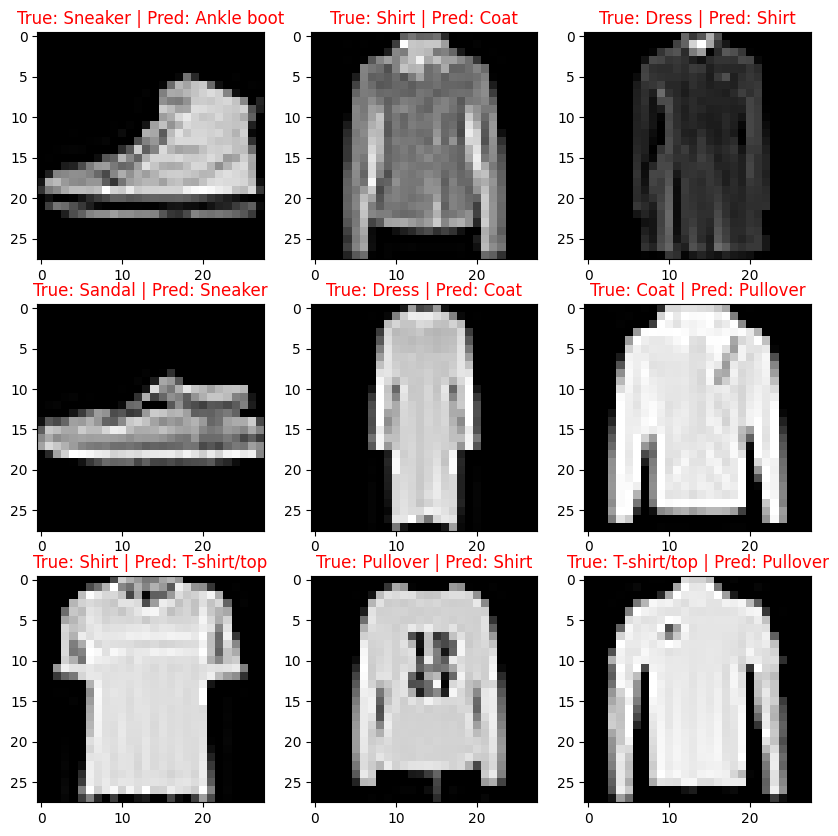

In [19]:
# Select random 9 wrong predictions and plot them
import random
import matplotlib.pyplot as plt

random_selection = random.sample(list(wrong_pred_indexes), k=9)

plt.figure(figsize=(10, 10))
for i, idx in enumerate(random_selection):
  # Get true and pred labels
  true_label = class_names[test_data[idx][1]]
  pred_label = class_names[test_preds[idx]]

  # Plot the wrong prediction with its original label
  plt.subplot(3, 3, i+1)
  plt.imshow(test_data[idx][0].squeeze(), cmap="gray")
  plt.title(f"True: {true_label} | Pred: {pred_label}", c="r")